# Clustering
* Preprocessing
* Modelling and results

In [1]:
import pandas as pd
import numpy as np

In [2]:
datamart = pd.read_csv('data/clustering_datamart.csv', index_col='CustomerID')
datamart.head()

,Recency,Frequency,Monetary_value,Breadth
CustomerID,,,,
12747,3,25,948.70,22
12748,1,888,7046.16,666
12749,4,37,813.45,36
12820,4,17,268.02,16
12822,71,9,146.15,9


In [3]:
datamart.shape

(3643, 4)

In [4]:
datamart.describe()

,Recency,Frequency,Monetary_value,Breadth
count,3643.00000,3643.000000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387,16.536646
std,94.44651,43.754468,1347.443451,29.228079
min,1.00000,1.000000,0.650000,1.000000
25%,19.00000,4.000000,58.705000,4.000000
50%,51.00000,9.000000,136.370000,9.000000
75%,139.00000,21.000000,334.350000,19.000000
max,365.00000,1497.000000,48060.350000,686.000000


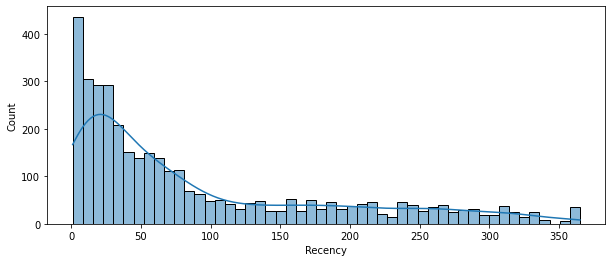

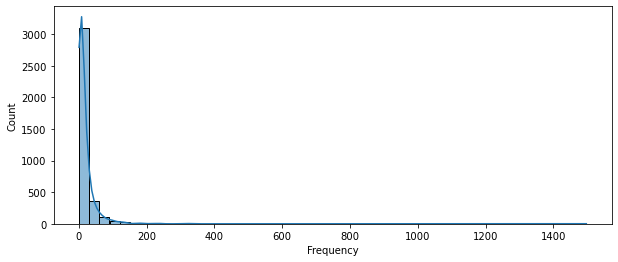

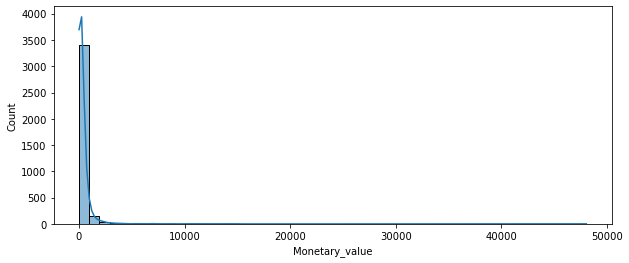

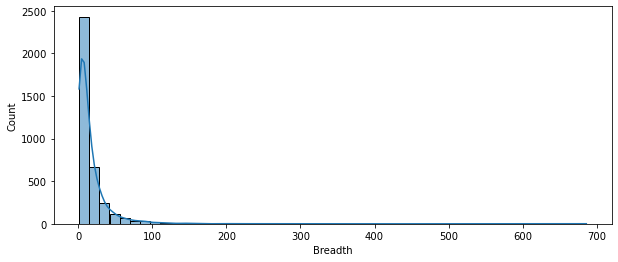

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

for abc in datamart.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=datamart, x=abc, bins=50, kde=True)
    plt.show()

## Data cleaning

There are extremely high numbers for Frequency, Monetary_value, Breadth. These outliers are unrealistically high and should be removed from the clustering since they constitute a very small and very anomalous segment of our clients. Eg:
* Customers that make more 400 purchases in a year
* Customers that spend more than 150,000 dollars a year
* Customers that purchase more than 100 different products 


We have 3 options to define a criteria for cleaning data of outliers. Percentiles, Interquartile range, Z-scores. Taking a look at the 99% percentiles of these features, the cutoff thresholds look reasonable and most of the acceptable data is within the range of data not to be removed. I will remove the clients who have data that are in the last 1% percentile of for Frequency and Breath, and remove clients from MV with intuitive threshold because the 99% percentiles of these features is still at a reasonable level ($25,000)

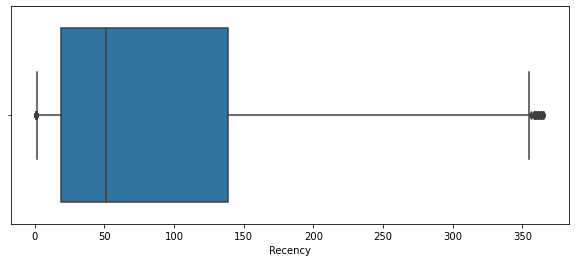

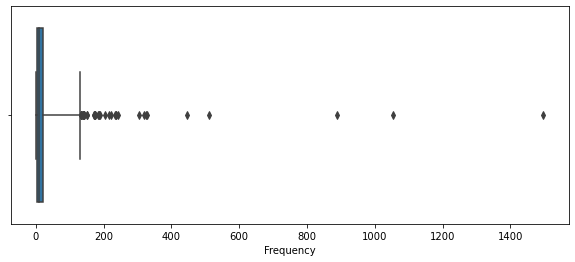

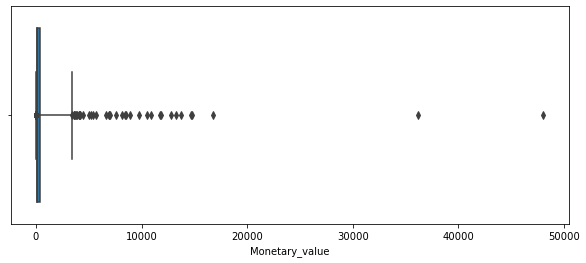

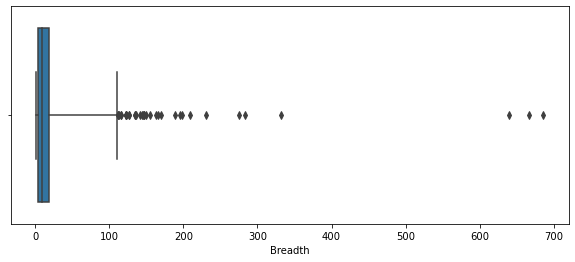

In [6]:
# whiskers are at 1.5 IQR by default
for abc in datamart.columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=datamart[abc], whis=[1,99])
    plt.show()

In [7]:
f_threshold = datamart['Frequency'].quantile(0.99)
print(f_threshold)
b_threshold = datamart['Breadth'].quantile(0.99)
print(b_threshold)
mv_threshold = 800000

131.73999999999978
110.0


In [8]:
datamart = datamart[datamart['Frequency']<=f_threshold]
datamart = datamart[datamart['Breadth']<=b_threshold]
datamart = datamart[datamart['Monetary_value']<=mv_threshold]
print(datamart.shape)

(3604, 4)


We only lost about 60 data points

# Transforming and scaling

K-means algorithm assumes a symmetric distribution of each variable. Variables are right skewed so they have to be transformed with log transformation. 

This algorithm uses a linear space distance metric, to give an equal weight to each variable the variables will be scaled to the same mean and variance.

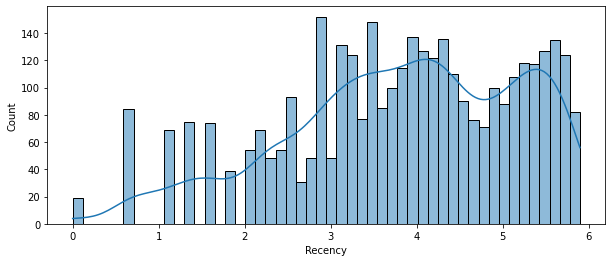

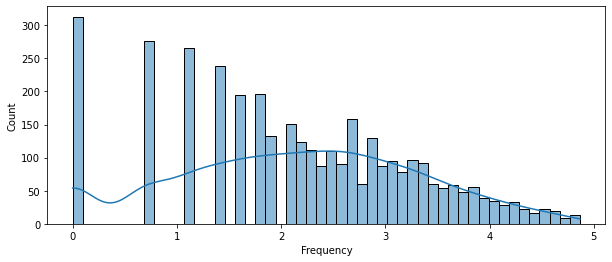

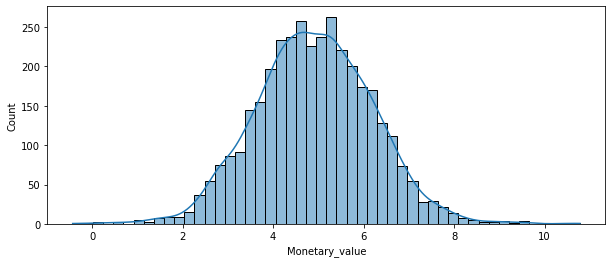

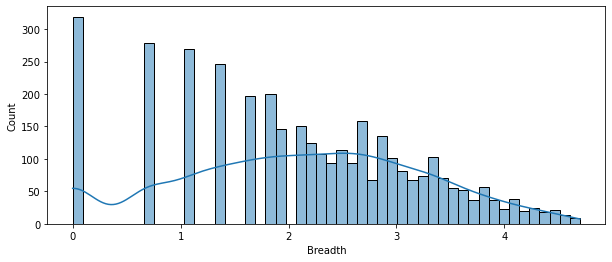

In [9]:
datamart_log = datamart.transform(np.log)
for abc in datamart_log.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=datamart_log, x=abc, bins=50, kde=True)
    plt.show()

The distribution is not perfectly symmetrical, but this is much more symmetrical than before

In [10]:
from sklearn.preprocessing import StandardScaler
# Good practice to save the scaler object splitting data with a train-test split for supervised learning

scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_scaled = scaler.transform(datamart_log)

In [11]:
print(datamart_scaled.mean(axis=0).round(2))
print(datamart_scaled.std(axis=0).round(2))

[-0. -0.  0.  0.]
[1. 1. 1. 1.]


The mean of each variable has been scaled to near 0, and the standard deviation has been scaled to 1

# Defining number of clusters
* Elbow method (Using Kmeans)
* Silhouette coefficient

The error metric used in Kmeans clustering is sum of squared distances which is the sum of squared errors from each data point to the centroid of the cluster it belongs to. This can be calculated with the inertia_ attribute of the Kmeans object.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

Fit clusters for 2
Fit clusters for 3
Fit clusters for 4
Fit clusters for 5
Fit clusters for 6
Fit clusters for 7
Fit clusters for 8
Fit clusters for 9
Fit clusters for 10
Fit clusters for 11
Fit clusters for 12
Fit clusters for 13
Fit clusters for 14
Fit clusters for 15


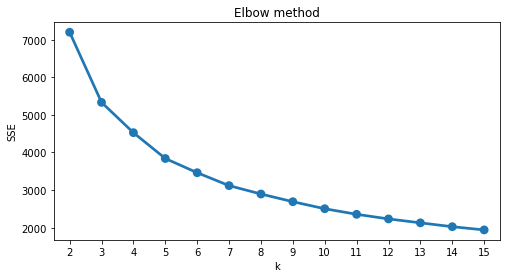

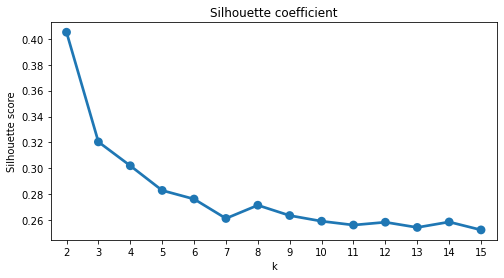

In [13]:
# Fit Kmeans model for each number of clusters
sse = {}
sil = {}
centroids = range(2, 16)

# Plot sum of squared distances
for n in centroids:
    km = KMeans(n_clusters=n, init='k-means++', random_state=1, n_init=15, max_iter=450)
    km.fit(datamart_scaled)
    print(f'Fit clusters for {n}')
    sse[n] = km.inertia_
    sil[n] = silhouette_score(datamart_scaled, km.labels_, metric='euclidean')
    
# Plot SSE scores
plt.figure(figsize=(8,4))
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8,4))
plt.title('Silhouette coefficient')
plt.xlabel('k')
plt.ylabel('Silhouette score')
sns.pointplot(x=list(sil.keys()), y=list(sil.values()))
plt.show()

In [14]:
def cluster_and_analyse(data_ml, n, data):
    # clustering
    km = KMeans(n_clusters=n, init='k-means++', random_state=1, n_init=15, max_iter=450)
    km.fit(data_ml)
    labels = km.labels_
    
    # assign labels to original data and analyse the average values
    datamart_clustered = data.assign(Cluster=labels)
    datamart_agg = datamart_clustered.groupby('Cluster').agg({
        'Recency':['mean', 'std'],
        'Frequency':['mean', 'std'],
        'Monetary_value':['mean', 'std'],
        'Breadth':['mean', 'std','count'],
    }).round(2)
    return datamart_agg

datamart_agg_5 = cluster_and_analyse(datamart_scaled, 5, datamart)
datamart_agg_6 = cluster_and_analyse(datamart_scaled, 6, datamart)

In [15]:
datamart_agg_5

Recency         Frequency        Monetary_value          Breadth  \
           mean     std      mean    std           mean      std    mean   
Cluster                                                                    
0         17.99   11.53      8.21   4.17         151.16   244.98    7.95   
1         66.23   55.35     21.10   9.95         352.14   366.25   20.02   
2         12.20   11.55     49.00  26.80        1190.07  2881.56   42.72   
3        160.31   88.96      6.40   3.05         143.52   472.64    6.29   
4        156.86  105.41      1.82   0.89          42.42    53.93    1.81   

                      
           std count  
Cluster               
0         4.01   588  
1         9.18   842  
2        22.45   564  
3         2.98   918  
4         0.89   692

In [16]:
datamart_agg_6

Recency        Frequency        Monetary_value          Breadth  \
           mean    std      mean    std           mean      std    mean   
Cluster                                                                   
0        158.24  87.56      7.19   3.28         153.06   479.20    7.07   
1         11.40  10.67     54.95  26.74        1383.56  3220.90   47.53   
2        185.14  97.86      1.78   0.89          42.56    52.98    1.77   
3         70.32  55.03     24.05  11.43         423.21   467.28   22.64   
4         30.55  18.93      3.95   1.74          87.02   216.87    3.89   
5         15.41   9.88     13.96   5.90         221.28   196.11   13.33   

                      
           std count  
Cluster               
0         3.20   893  
1        22.45   440  
2         0.87   611  
3        10.42   680  
4         1.72   435  
5         5.61   545

These silhouete coefficients are pretty bad and the std's of the clusters are high compared to the mean, suggesting poor clustering results.

I will repeat the preprocessing and only apply log to **Frequency, Monetary_value, breadth**  because they are the only variable with a somewhat symmetrical KDE distribution after the transformation. Transforming the other features without a the result being a symmetrical distribution could be a detrimental step in pre-processing.

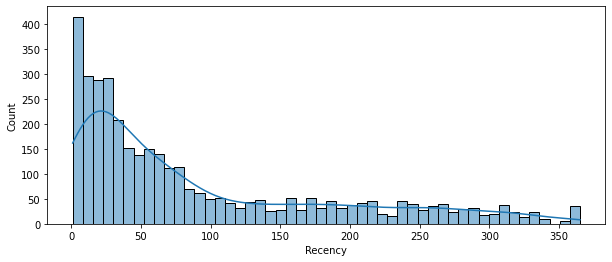

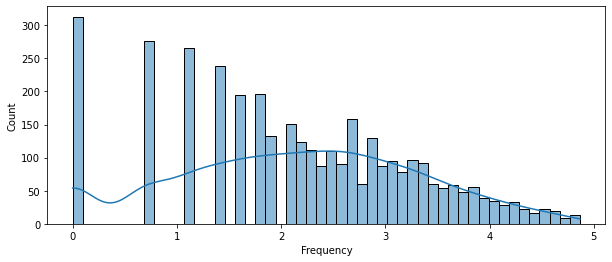

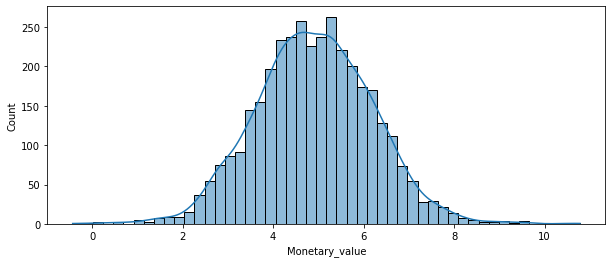

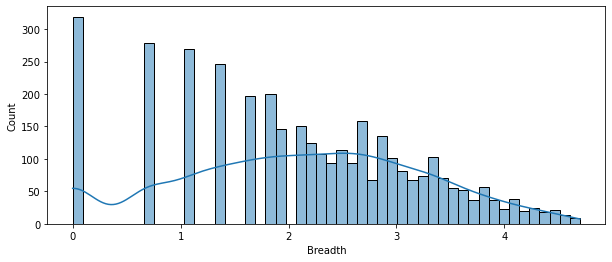

Fit clusters for 2
Fit clusters for 3
Fit clusters for 4
Fit clusters for 5
Fit clusters for 6
Fit clusters for 7
Fit clusters for 8
Fit clusters for 9
Fit clusters for 10
Fit clusters for 11
Fit clusters for 12
Fit clusters for 13
Fit clusters for 14
Fit clusters for 15


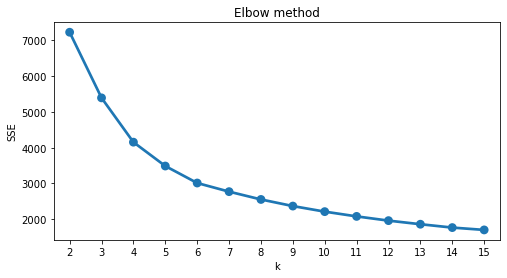

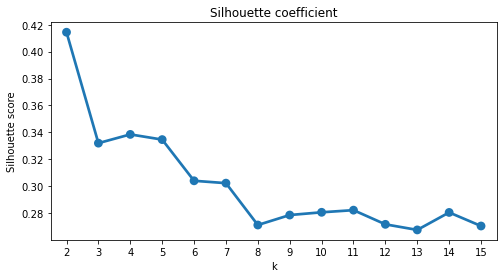

In [17]:
datamart_log = datamart.copy()
datamart_log['Frequency'] = np.log(datamart['Frequency'])
datamart_log['Monetary_value'] = np.log(datamart['Monetary_value'])
datamart_log['Breadth'] = np.log(datamart['Breadth'])

for abc in datamart_log.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=datamart_log, x=abc, bins=50, kde=True)
    plt.show()
    
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_scaled = scaler.transform(datamart_log)

# Fit Kmeans model for each number of clusters
sse = {}
sil = {}
centroids = range(2, 16)

# Plot sum of squared distances
for n in centroids:
    km = KMeans(n_clusters=n, init='k-means++', random_state=1, n_init=15, max_iter=450)
    km.fit(datamart_scaled)
    print(f'Fit clusters for {n}')
    sse[n] = km.inertia_
    sil[n] = silhouette_score(datamart_scaled, km.labels_, metric='euclidean')
    
# Plot SSE scores
plt.figure(figsize=(8,4))
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8,4))
plt.title('Silhouette coefficient')
plt.xlabel('k')
plt.ylabel('Silhouette score')
sns.pointplot(x=list(sil.keys()), y=list(sil.values()))
plt.show()

#### 5 and 6 clusters appear to be good because the silhouette scores are around 0.30/0.33 instead of 0.28, and the sharpest change in the angle of the elbow method is at 5 and 6

# Interpreting the segments of 5 and 6 kmeans clusters

I will take a look at the standard dev, not just the mean of each segment to get an idea of how well clustered the features are

In [21]:
datamart_agg_5 = cluster_and_analyse(datamart_scaled, 5, datamart)
datamart_agg_6 = cluster_and_analyse(datamart_scaled, 6, datamart)

In [22]:
datamart_agg_5

Recency        Frequency        Monetary_value          Breadth  \
           mean    std      mean    std           mean      std    mean   
Cluster                                                                   
0         47.78  37.85     12.54   5.41         218.80   207.91   12.07   
1        245.64  62.49      1.88   0.94          43.13    54.57    1.86   
2         55.17  37.48      3.13   1.62          77.39   182.76    3.09   
3        230.65  60.16      7.99   5.01         169.04   649.43    7.85   
4         27.48  31.57     44.33  24.25        1001.51  2456.28   39.26   

                      
           std count  
Cluster               
0         5.18  1207  
1         0.92   400  
2         1.60   715  
3         4.88   484  
4        20.20   798

In [23]:
datamart_agg_6

Recency        Frequency        Monetary_value          Breadth  \
           mean    std      mean    std           mean      std    mean   
Cluster                                                                   
0         52.23  36.66      6.43   2.39         139.90   212.45    6.30   
1         46.16  41.80     17.85   6.81         280.21   213.74   16.99   
2        252.80  57.22      1.95   0.97          46.55    62.38    1.94   
3        233.63  58.38      7.97   4.86         168.65   667.29    7.83   
4         60.33  39.65      2.00   0.95          47.85    77.24    1.98   
5         23.18  25.62     50.61  24.95        1221.24  2814.79   44.35   

                      
           std count  
Cluster               
0         2.35   796  
1         6.44   953  
2         0.95   386  
3         4.73   457  
4         0.94   419  
5        20.83   593

# Customer behaviour analysis for cluster 5

<u>5 cluster</u>

Cluster 0 and 4 have avg recency at 27/27 and freqncy ot 12/44. This makes a good cluster for target promotions and discounts because they are clusters of loyal customers. And together form about 1600 clients

Cluster 1 and 3 look like churned customers because of the low Recency and Frequency. They also have only bought 1 or 7 products. Cluster 1 should be introduced to new products to ingnite their interest in our products. 

Cluster 2 and 3 looks like a one time purchase cluster who are interested in very specific products based high ratio of Monetary value to Frequency. Perhaps their interests could be analysed to market similar products to them since they are clearly willing to pay money for specific products of interest to them